In [1]:
import os
import pandas as pd
import re
import string
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

In [2]:
ham_dir = r"..\data\extracted_emails\easy_ham"
spam_dir = r"..\data\extracted_emails\spam"

In [3]:
def load_emails(directory, label):
    emails = []
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        with open(filepath, "r", encoding="utf-8", errors='ignore') as file:
            content = file.read()
            emails.append((content, label))
    return emails

In [4]:

ham_emails = load_emails(ham_dir, 0)  # 0 for Not Spam
spam_emails = load_emails(spam_dir, 1)  # 1 for spam

data = ham_emails + spam_emails

df = pd.DataFrame(data, columns=["text", "label"])

In [ ]:
df.head()


,text,label
0,From exmh-workers-admin@redhat.com Thu Aug 22...,0
1,From Steve_Burt@cursor-system.com Thu Aug 22 ...,0
2,From timc@2ubh.com Thu Aug 22 13:52:59 2002\n...,0
3,From irregulars-admin@tb.tf Thu Aug 22 14:23:...,0
4,From exmh-users-admin@redhat.com Thu Aug 22 1...,0
...,...,...
95,From DNS-swap@lists.ironclad.net.au Mon Sep ...,0
96,From webster@ryanairmail.com Mon Sep 2 12:30...,0
97,From updates-admin@ximian.com Mon Sep 2 12:2...,0
98,From 0xdeadbeef-request@petting-zoo.net Mon S...,0


In [6]:
(df['label'].value_counts() / len(df)) * 100

label
0    71.79848
1    28.20152
Name: count, dtype: float64

In [7]:
df['label'].value_counts()

label
0    2551
1    1002
Name: count, dtype: int64

In [8]:
# Preprocessing the as needed Data 
def clean_text(text):
    text = re.sub(r"\n", " ", text)  
    text = re.sub(r"\S+@\S+", "", text)  
    text = re.sub(r"http\S+", "", text) 
    text = text.translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
    text = text.lower()                                               # convert to lowercase for easy to use
    return text

df["text"] = df["text"].apply(clean_text)

# Data split

In [9]:

X_train, X_test, y_train, y_test = train_test_split(df["text"], df["label"], test_size=0.3, random_state=42)

# Feature Extraction

In [10]:

vectorizer = TfidfVectorizer(stop_words="english")
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train model

In [11]:

model = MultinomialNB()
model.fit(X_train_tfidf, y_train)


MultinomialNB()

In [12]:

y_pred = model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9052532833020638
Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.94       759
           1       1.00      0.67      0.80       307

    accuracy                           0.91      1066
   macro avg       0.94      0.84      0.87      1066
weighted avg       0.92      0.91      0.90      1066



# Confusion Matrix

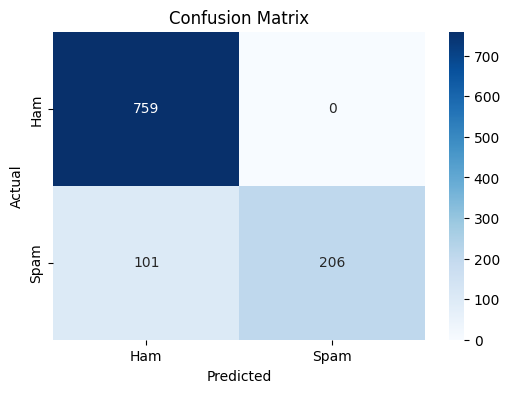

In [13]:

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [14]:
accuracy = accuracy_score(y_test, y_pred)


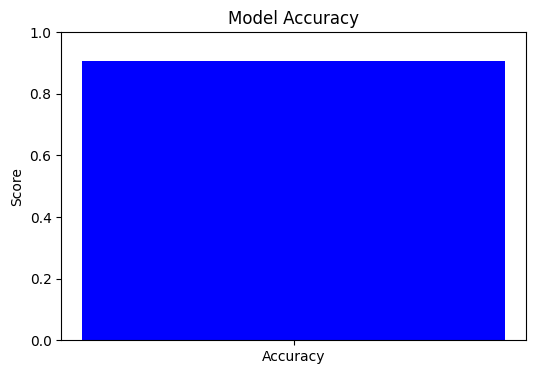

In [15]:
# Accuracy plot
plt.figure(figsize=(6, 4))
plt.bar(["Accuracy"], [accuracy], color='blue')
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Model Accuracy")
plt.show()


In [16]:
# Sample Test

def predict_email(text):
    cleaned_text = clean_text(text)
    text_tfidf = vectorizer.transform([cleaned_text])
    prediction = model.predict(text_tfidf)[0]
    return "Spam" if prediction == 1 else "Not-Spam"


email_text = """ 
1) Fight The Risk of Cancer!
http://www.adclick.ws/p.cfm?o=315&s=pk007

2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days
http://www.adclick.ws/p.cfm?o=249&s=pk007

3) Get the Child Support You Deserve - Free Legal Advice
http://www.adclick.ws/p.cfm?o=245&s=pk002

4) Join the Web's Fastest Growing Singles Community
http://www.adclick.ws/p.cfm?o=259&s=pk007

5) Start Your Private Photo Album Online!
http://www.adclick.ws/p.cfm?o=283&s=pk007

Have a Wonderful Day,
Offer Manager
PrizeMama

"""
print("Prediction:", predict_email(email_text))

Prediction: Spam


In [17]:
with open(os.path.join("../models", "spam_classifier.pkl"), "wb") as model_file:
    pickle.dump((vectorizer, model), model_file)

